In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

BATCH_SIZE = 16
IMAGE_SIZE = 227
CHANNELS=3
EPOCHS=100

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/synthesis-1/combined dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
print(class_names)

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

len(dataset)
train_size = 0.8
train_len = len(dataset)*train_size
print(train_len)

train_ds = dataset.take(int(train_len))
print(len(train_ds))

test_ds = dataset.skip(len(train_ds))
print(len(test_ds))

val_size = 0.1
val_train = len(dataset)*val_size
print(val_train)

val_ds = test_ds.take(int(val_train))
print(len(val_ds))

test_ds = test_ds.skip(len(val_ds))
print(len(test_ds))

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])


data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)




Found 1811 files belonging to 5 classes.
['Charlock', 'Fat Hen', 'Maize', 'Shepherds Purse', 'Small-flowered Cranesbill']
(16, 227, 227, 3)
[2 2 1 4 4 0 4 0 2 0 4 2 0 1 3 4]
91.2
91
23
11.4
11
12


In [5]:
  from keras import initializers

In [6]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 227  # Adjusted to match typical AlexNet input
CHANNELS = 3
n_classes = 5

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Define the model
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    
    layers.Conv2D(96, kernel_size=(11,11), strides=(4,4), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    layers.Conv2D(256, kernel_size=(5,5), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    layers.Conv2D(384, kernel_size=(3,3), activation='relu', padding='same'),
    layers.Conv2D(384, kernel_size=(3,3), activation='relu', padding='same'),
    layers.Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])


early_stopping = EarlyStopping(
    monitor='val_accuracy',  
    patience=55,  
    restore_best_weights=True  
)



optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.001,
    momentum=0.9,
    decay=0.0001,
    nesterov=False  
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 227, 227, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_3 (RandomFlip)      │ (None, 227, 227, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_3               │ (None, 227, 227, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 57, 57, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 28, 28, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │        20,485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,301,829 (222.40 MB)

 Trainable params: 58,301,829 (222.40 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:

history = model.fit(
    train_ds,  
    validation_data=val_ds,  
    epochs=100,
    batch_size=32,
    callbacks = [early_stopping]
)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.9710 - loss: 0.1060 - val_accuracy: 0.9830 - val_loss: 0.0756
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.9615 - loss: 0.1281 - val_accuracy: 0.9659 - val_loss: 0.0735
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.9663 - loss: 0.1256 - val_accuracy: 0.9602 - val_loss: 0.0845
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.9598 - loss: 0.1273 - val_accuracy: 0.9773 - val_loss: 0.0721
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.9559 - loss: 0.1273 - val_accuracy: 0.9886 - val_loss: 0.0510
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.9734 - loss: 0.1069 - val_accuracy: 0.9602 - val_loss: 0.0828
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9506 - loss: 0.1422 - val_accuracy: 0.9830 - val_loss: 0.0408
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.9716 - loss: 0.1003 - 

KeyboardInterrupt: 

In [15]:
scores = model.evaluate(test_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9743 - loss: 0.0839


first image to predict
actual label: Charlock
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
predicted label: Charlock


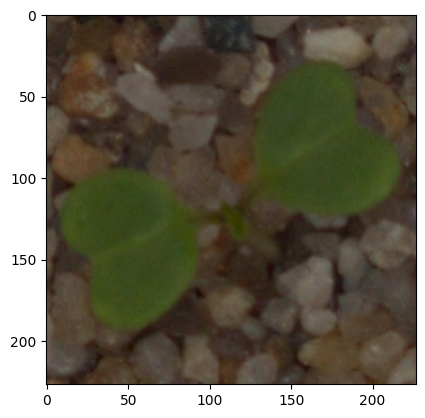

In [16]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [17]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


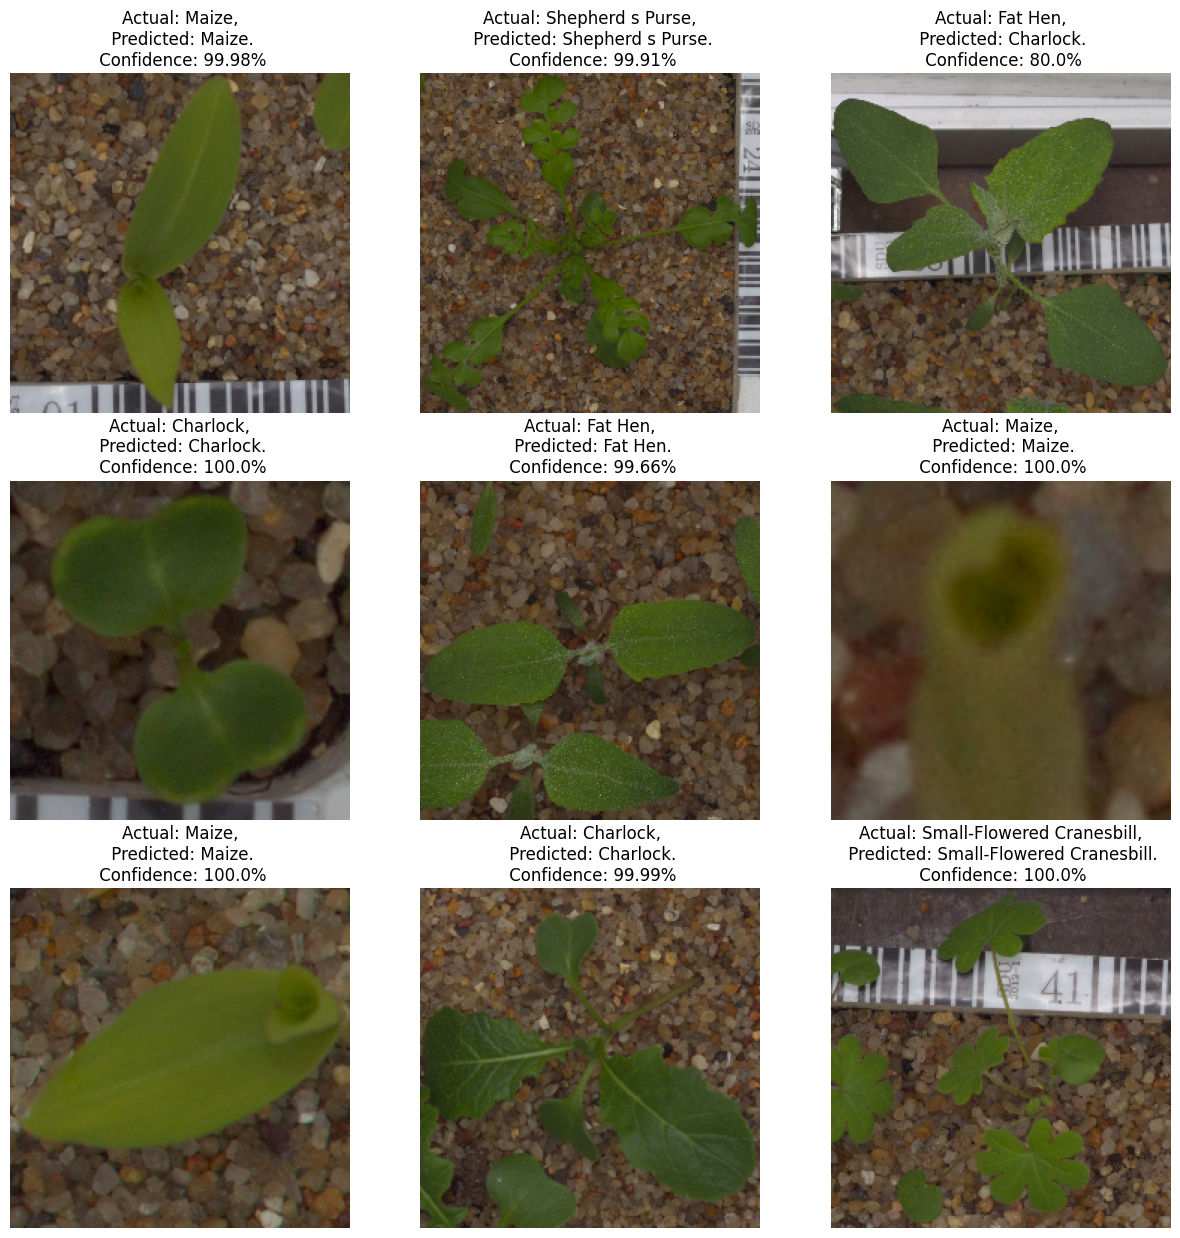

In [18]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [19]:
import numpy as np
from sklearn.metrics import f1_score
import tensorflow as tf

test_images = []
test_labels = []

for images, labels in test_ds:
    # Convert the images and labels to arrays
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

# Convert test_images and test_labels to numpy arrays
test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)


predicted_probabilities = model.predict(test_images)

# Convert the predicted probabilities to class labels using `np.argmax`
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Ensure `test_labels` and `predicted_classes` are both in the same format (e.g., numpy arrays)
true_labels = np.array(test_labels)


f1 = f1_score(true_labels, predicted_classes, average='weighted')

# Print the F1 score
print(f"F1 Score (weighted): {f1}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
F1 Score (weighted): 0.9733251633986928
